In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import operator

# pyro imports
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoMultivariateNormal

import os
import sys
sys.path.append("../src") if "../src" not in sys.path else None 

# custom imports
from methods import *
from nnmodules import GenericDNN, MND_BNN
from evaluation import * 

### Initialize Data

In [3]:
# choose dataset to use
dataset_name = 'yacht.txt'#'energy_heating_load.txt'#
datasets_path = '../datasets/'
dataset_path = datasets_path + dataset_name

# load data and create torch training data loader
(X_train, y_train), (X_test, y_test) = load_data(dataset_path)
trainloader = torch.utils.data.DataLoader(Dataset(X_train, y_train, dataset_name.split('.')[0], normalize=True), 
                                         batch_size:=128, shuffle:=True)

In [4]:
net = MND_BNN(input_size:=X_train.shape[-1], hidden_size:=input_size, output_size:=1)

### Dev

In [5]:
def train(svi, train_loader, batch_size, use_cuda=False):
    epoch_loss = 0.
    
    for i, (X, y) in enumerate(train_loader):
        epoch_loss += svi.step(X,y)
        
    N = len(train_loader.dataset)
    return epoch_loss / N

def evaluate(svi, test_loader, batch_size, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
        
    N = len(test_loader.dataset)
    return test_loss / N

In [6]:
# clear param store
pyro.clear_param_store()

# setup the optimizer
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(net.model, net.guide, optimizer, loss=Trace_ELBO())
# svi = SVI(net.model, AutoMultivariateNormal(net.model), optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS:=5000):
    total_epoch_loss_train = train(svi, trainloader, batch_size)
    train_elbo.append(-total_epoch_loss_train)
    if not (epoch % 100):
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    """
    # report test diagnostics
    total_epoch_loss_test = evaluate(svi, test_loader, batch_size)
    test_elbo.append(-total_epoch_loss_test)
    print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
    """

[epoch 000]  average training loss: 2554.2758
[epoch 100]  average training loss: 1163.4479
[epoch 200]  average training loss: 753.3778
[epoch 300]  average training loss: 478.8876
[epoch 400]  average training loss: 443.3706
[epoch 500]  average training loss: 394.4578
[epoch 600]  average training loss: 337.4074
[epoch 700]  average training loss: 281.7137
[epoch 800]  average training loss: 284.7847
[epoch 900]  average training loss: 274.1401
[epoch 1000]  average training loss: 250.6392
[epoch 1100]  average training loss: 243.5426
[epoch 1200]  average training loss: 234.1732
[epoch 1300]  average training loss: 220.4942
[epoch 1400]  average training loss: 213.1017
[epoch 1500]  average training loss: 200.2111
[epoch 1600]  average training loss: 205.4861
[epoch 1700]  average training loss: 190.1409
[epoch 1800]  average training loss: 191.0769
[epoch 1900]  average training loss: 187.9373
[epoch 2000]  average training loss: 188.7334
[epoch 2100]  average training loss: 178.7

Text(0.5, 0.98, 'True vs Predicted')

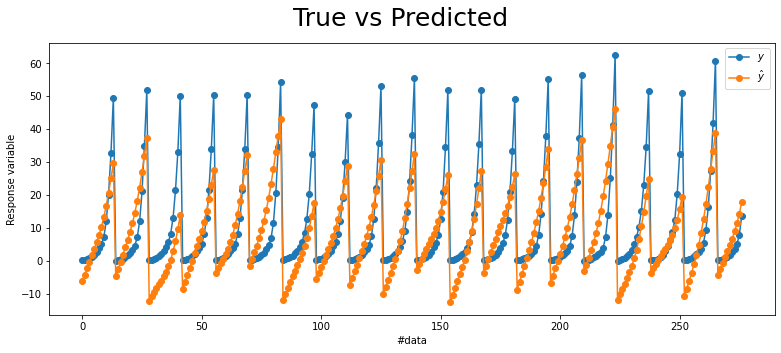

In [15]:
W1, W2 = net.sample_weights()
# model prediction
preds = net(trainloader.dataset[:][0], W1, W2).detach().numpy() # forward dataset
preds = preds * trainloader.dataset.stdy + trainloader.dataset.muy # rescale

# plotting
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(y_train, "-o", label="$y$")
ax.plot(preds, "-o", label="$\hat{y}$")
ax.set_xlabel("#data")
ax.set_ylabel("Response variable")
ax.legend()
fig.suptitle("True vs Predicted", size=25)

In [8]:
W1, W2

(tensor([[ 0.9445, -0.2989,  0.1160, -0.0411,  2.2177,  0.0932, -1.1567],
         [-1.6178, -0.3053, -0.4868,  0.4483,  0.2786, -1.9557, -0.8931],
         [-0.2570, -0.5987,  0.0562, -0.6046, -1.3204, -1.2250, -0.4657],
         [-1.0508,  1.3340, -1.7152,  0.7813,  1.1747,  1.3536,  0.2184],
         [-1.1037, -1.4189, -0.2146, -1.3575, -0.0401,  0.7834,  0.5095],
         [-0.0179, -0.1613,  0.3839, -0.6906, -0.2752,  2.9310, -1.3338],
         [-0.0640, -0.3567, -0.9849, -0.1846, -1.3960, -0.9400,  1.0409]]),
 tensor([[-0.0270,  0.0155, -0.0767, -0.0233,  0.0721,  0.5003, -0.0144]]))

In [9]:
for key, value in pyro.get_param_store().items():
    print(key, value)

mu_W1 tensor([-1.2704e-01, -4.5558e-03, -6.1816e-03, -1.6580e-02, -2.6416e-03,
         1.0296e-02, -1.9418e-01,  6.8296e-03, -1.3521e-01,  3.3689e-03,
        -4.2916e-02,  6.5747e-03, -4.7997e-03, -1.8705e-01, -3.3273e-02,
        -5.4082e-03, -1.1092e-01, -4.8757e-02, -7.7447e-02,  3.9554e-03,
        -1.9652e-01, -1.8697e-02, -4.3239e-02, -3.4328e-02, -9.4549e-02,
         4.1893e-02,  8.1561e-03, -1.9084e-01, -3.3480e-02, -2.9353e-02,
        -7.5032e-02,  1.3207e-02, -9.5892e-02,  8.4814e-04, -1.7984e-01,
         1.8776e-01, -6.8897e-02,  3.7139e-02, -5.1058e-02,  3.0392e-04,
         2.3661e+00, -1.4824e+00, -4.7522e-02, -5.8295e-02, -5.0957e-02,
        -3.3477e-02, -3.5274e-02,  6.8957e-02, -1.7875e-01],
       requires_grad=True)
mu_W2 tensor([-0.0245, -0.0114, -0.0186, -0.0183, -0.0225,  0.4820, -0.0815],
       requires_grad=True)
U1 tensor([[7.7669e-01, 2.4955e-04, 8.4217e-04, 9.6459e-04, 2.5505e-03, 1.5056e-04,
         3.9332e-03],
        [7.0796e-03, 7.8161e-01, 2.999

In [10]:
_,tril_cov1,_,tril_cov2 = pyro.get_param_store().values()

ValueError: too many values to unpack (expected 4)

In [ ]:
tril_cov1.T @ tril_cov1, tril_cov2.T @ tril_cov2

In [ ]:
mu_W1 tensor([-0.4735, -1.2331, -0.1797,  0.7297, -0.0213,  0.2419, -0.4962, -1.0375,
        -0.1040,  0.4343,  1.4010, -0.2671, -1.8023, -0.0973, -0.9529, -0.3093,
         0.3328, -0.1505, -0.0125,  0.2335,  0.1977,  0.3960, -0.5815, -0.3908,
         0.0837,  0.0549, -0.5702, -0.0463,  0.3576,  0.0869,  0.0939,  0.9108,
         0.0049, -0.0217,  0.0737, -0.1494], requires_grad=True)
cov_W1 tensor([[0.7841, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7822, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8001,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.7766, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7514, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7400]],
       grad_fn=<AddBackward0>)
mu_W2 tensor([-0.1610, -0.8979,  0.5163,  0.4078, -0.1781, -0.4093],
       requires_grad=True)
cov_W2 tensor([[0.5968, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6162, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5849, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6089, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6069, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5945]],
       grad_fn=<AddBackward0>)